# Data-driven research - project 19.06.2022
## Norbert Burmistrzak, Zuzanna Miazio

The aim of the project is to conduct text analysis on two datasets: Reddit comments before and after the outbreak of the war in Ukraine. The issues concern Poland and Polish politicians. The analysis is to verify whether the perception and frequency of occurrence of selected issues has changed as a result of the ethical attitude of the society towards war refugees.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import SnowballStemmer
import vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Database creation

The database was created from comments on Reddit. The following subbreds were selected: europe, worldnews, news, politics and geopolitics. They concern the most important events in the world and are widely commented on, which allowed to obtain a large number of observations. In addition, they correspond to the idea of the work, which was to focus mainly on social and political issues.

Two separate databases were created. The first contains comments written after the outbreak of war. The second contains information from 01/01/2019 to 24/02/2022. The lower bound ensures that the scraper will not pick comments posted a long time ago.

In [2]:
from pmaw import PushshiftAPI
api = PushshiftAPI() # Occasionally, the Pushshift API does not return any comments due to API outages. 

In [3]:
start_epoch = int(dt.datetime(2022, 2, 24).timestamp())
end_epoch = int(dt.datetime(2022, 5, 11).timestamp())

In [4]:
subreddits = ['europe', 'worldnews', 'news', 'politics', 'geopolitics']
words = '(Poland)|(Polish)|(Poles)|(PL)|(Złoty)|(Morawiecki)|(Andrzej Duda)|(Kaczyński)|(Warsaw)|'
df_after_war = pd.DataFrame([])

for sreddit in subreddits:

    api_request_generator = api.search_comments(after=start_epoch, before=end_epoch, q=words, subreddit=sreddit, limit = None,
                                                   filter=['author', 'date', 'title', 'body', 'url', 'subreddit', 'score'])


    temp = pd.DataFrame([submission.d_ for submission in api_request_generator])
    df_after_war = pd.concat([df_after_war, temp])
    
# save to csv file so you don't have to download every time
df_after_war.to_csv('data_after_war.csv')

In [5]:
df_after_war = pd.read_csv('data_after_war.csv')

The second database contains information from 01/01/2019 to 01/05/2021. The lower bound of the range ensures that the scraper will not pick up comments posted a long time ago. The upper one was set six months before the start of the conflict, because the war has been talked about for a long time and there is a risk that it could distort the data and their long-term trend.

In [6]:
end_epoch=int(dt.datetime(2021, 5, 1).timestamp())
start_epoch=int(dt.datetime(2019, 1, 1).timestamp())

In [7]:
# limits were set to get a similar number of comments from each subreddit
df_after_war['subreddit'].value_counts()

europe         9991
worldnews      9928
news           2688
politics       1981
geopolitics     711
Name: subreddit, dtype: int64

In [8]:
subreddits = [['europe',9991], ['worldnews',9928], ['news',2688], ['politics',1981], ['geopolitics',711]]
words = '(Poland)|(Polish)|(Poles)|(PL)|(Złoty)|(Morawiecki)|(Andrzej Duda)|(Kaczyński)|(Warsaw)|'
df_before_war = pd.DataFrame([])

for sreddit in subreddits:

    api_request_generator = api.search_comments(after=start_epoch, before=end_epoch, q=words, subreddit=sreddit[0], limit = sreddit[1],
                                                   filter=['author', 'date', 'title', 'body', 'url', 'subreddit', 'score'])


    temp = pd.DataFrame([submission.d_ for submission in api_request_generator])
    df_before_war = pd.concat([df_before_war, temp])

# save to csv file so you don't have to download every time
df_before_war.to_csv('data_before_war.csv')

In [9]:
df_before_war = pd.read_csv('data_before_war.csv')

In [10]:
df_before_war['created_utc'] = pd.to_datetime(df_before_war['created_utc'], utc=True, unit='s')
df_after_war['created_utc'] = pd.to_datetime(df_after_war['created_utc'], utc=True, unit='s')
df_before_war.head()

,Unnamed: 0,author,body,created_utc,score,subreddit,created
0,0,Reditp,I'm polish and I wouldn't want to protect this...,2021-04-30 21:45:10+00:00,0,europe,1.619812e+09
1,1,I_love_limey_butts,"This must've been before he invaded Poland, ba...",2021-04-30 21:24:15+00:00,2,europe,1.619811e+09
2,2,Sugar_Free_RedBull,Poland right after USA? What have the pierogi ...,2021-04-30 21:22:18+00:00,2,europe,1.619811e+09
3,3,jewish_deepthroater,&gt;I get the sense Poles would rather die tha...,2021-04-30 21:19:05+00:00,3,europe,1.619810e+09
4,4,blablaminek,the support for gay marriage/civil unions is h...,2021-04-30 21:18:03+00:00,3,europe,1.619810e+09


## Text mining

In [11]:
stopword_list=stopwords.words('english')
st = SnowballStemmer('english')

In [12]:
# # a list of meaningless words that occur frequently and contribute nothing to the analysis
meaningless_words = ['\'s', 'n\'t', 'gt', '``', 'one', 'https', 'also', 'even', 'get', 'go', 'want', 'say', 'year', 'time', 'thing', 'much', 'know', '...', 'use','\'\'',
                    'think', 're', 'make', 'could', 'mani', 'still', 'mean', '\'m', 'well', 'live', 'need', 'amp', 'look', 'take', 'like', 'would']
stopword_list.extend(meaningless_words)

In [13]:
# text processing for text mining
def text_processing(df):
    df['text']=df['body'].apply(lambda x: word_tokenize(x)) # split into single words
    df['text']=df['text'].apply(lambda row: [i.lower() for i in row]) # convert to lowercase
    df['text']=df['text'].apply(lambda row: [i for i in row if i not in stopword_list and len(i)>1] ) # remove words like the, an, and
    df['text_st']=df['text'].apply(lambda row: [st.stem(i) for i in row ] ) # word variety

text_processing(df_before_war)
text_processing(df_after_war)

In [14]:
# most common words
def most_common_words(df):
    frequencies = Counter()
    for i, row in df.iterrows():
        counts=Counter(row['text_st'])
        frequencies.update(counts)
    print(frequencies.most_common()[:20])

In [15]:
most_common_words(df_before_war)

[('poland', 18832), ('peopl', 8916), ('countri', 8913), ('polish', 8455), ('germani', 4923), ('russia', 4792), ('eu', 4530), ('us', 4328), ('pole', 3794), ('war', 3707), ('europ', 3551), ('right', 3444), ('state', 3356), ('german', 3015), ('govern', 2802), ('russian', 2664), ('re', 2639), ('mani', 2518), ('see', 2470), ('year', 2426)]


The topics of the selected subreddits concern news and politics, so the most common words before the war are country, people, state, government. The words germany, eu, us, russia are also frequent. These countries are Poland's largest political and economic partners, so news on the international arena mainly mentions them. The noun war was also relatively popular before the war, probably because the potential conflict in Ukraine had already been discussed much earlier, and also due to the popularity of historical articles about World War II

In [16]:
# the most common words after the outbreak of war
most_common_words(df_after_war)

[('poland', 23037), ('russia', 12731), ('ukrain', 11721), ('countri', 9101), ('russian', 8086), ('germani', 7299), ('war', 6421), ('polish', 6364), ('nato', 5884), ('peopl', 5737), ('eu', 5662), ('us', 5451), ('ukrainian', 3841), ('putin', 3830), ('europ', 3470), ('german', 3427), ('state', 3356), ('gas', 3211), ('right', 3095), ('said', 3015)]


After the outbreak of war, posts about the conflict definitely dominated Reddit. There was an almost three-fold increase in the occurrence of the word Russia, almost four times russian and two times war. Moreover, terms such as ukraine (as many as 11,721 occurrences), ukrainian, putin, gas, nato appear.

In [17]:
# what words often occurred in pairs
def pairs(df): 
    pairs = Counter()
    for i, row in df.iterrows():
        counts=Counter(list(nltk.bigrams(row['text_st'])))
        pairs.update(counts)
    print(pairs.most_common()[:10])

In [18]:
pairs(df_before_war)

[(('poland', 'hungari'), 695), (('polish', 'peopl'), 611), (('invad', 'poland'), 550), (('nail', 'polish'), 530), (('eastern', 'europ'), 515), (('--', '--'), 463), (('warsaw', 'pact'), 461), (('european', 'countri'), 456), (('soviet', 'union'), 444), (('hungari', 'poland'), 410)]


In the database relating to the period before the outbreak of the war, the connection poland and hungary appears twice, which proves that Hungarians are Poland's main political partner and the media often write about it. There is also a soviet-union, which confirms the thesis about the high popularity of historical news. The others are rather random and hard to assign meaning to them

In [19]:
# after war 
pairs(df_after_war)

[(('russian', 'gas'), 738), (('warsaw', 'pact'), 703), (('poland', 'hungari'), 641), (('invad', 'poland'), 627), (('soviet', 'union'), 621), (('eastern', 'europ'), 534), (('nato', 'countri'), 468), (('european', 'countri'), 416), (('hungari', 'poland'), 411), (('unit', 'state'), 410)]


After the outbreak of war, russian-gas appears most often, most likely in relation to economic sanctions. NATO-countries and united-states are very common, so a lot of comments about the state's allies and foreign policy were written during this time. Summing up, the thesis that Reddit is dominated by the subject of war is again confirmed.

In [20]:
# dividing the text into paragraphs, needed for further analysis
def divide(df):
    df['text_p']=df['body'].str.split('\n\n')
    df['text_p']=df['text_p'].apply(lambda x: [i.lower() for i in x])
    text=[]
    for i,j in df.iterrows():
        for l in j['text_p']:
            text.append(l)
    token=[]
    for i in text:
        token.append(word_tokenize(i))
    text = [[i for i in j if i not in stopword_list and len(i)>1] for j in token]
    text = [[st.stem(x) for x in j] for j in text]
    return text

text_before = divide(df_before_war)
text_after = divide(df_after_war)

In [21]:
# how often do words selected for analysis occur?
words = ['poland', 'polish', 'poles', 'pl', 'złoty', 'warsaw', 'morawiecki', 'andrzej duda' ,'kaczyński']
for word in words:
    w=[i for i in text_before if word in i]
    print(word, len(w))

poland 16761
polish 7491
poles 0
pl 139
złoty 0
warsaw 1467
morawiecki 46
andrzej duda 0
kaczyński 76


In [22]:
# after war 
for word in words:
    w=[i for i in text_after if word in i]
    print(word, len(w))

poland 20216
polish 5667
poles 0
pl 80
złoty 0
warsaw 1419
morawiecki 258
andrzej duda 0
kaczyński 119


The frequency of occurrence of the words we selected is similar in both datasets. An interesting observation is that after the outbreak of the war, Mateusz Morawiecki's popularity in downloaded comments increased more than five times. Jarosław Kaczyński recorded an almost two-fold increase. Three of the selected keywords did not find any occurrences. The words poles, zloty and Andrzej Duda did not appear in the comments before or after the escalation of the conflict.

## Sentiment analysis
The next step in our analysis is sentiment analysis.

In [23]:
analyzer = SentimentIntensityAnalyzer()

In [24]:
def sentiment(df):
    df['sentiment']=df['body'].apply(lambda x: analyzer.polarity_scores(x))
    df['sentiment_score']=df['sentiment'].apply(lambda x: x['compound'])
    df['sentiment_pos']=df['sentiment'].apply(lambda x: x['pos'])
    df['sentiment_neg']=df['sentiment'].apply(lambda x: x['neg'])
    
sentiment(df_before_war)
sentiment(df_after_war)

In [25]:
df_before_war[['body', 'sentiment_score', 'sentiment_pos', 'sentiment_neg', 'sentiment_score']].head()

,body,sentiment_score,sentiment_pos,sentiment_neg,sentiment_score
0,I'm polish and I wouldn't want to protect this...,-0.3412,0.000,0.299,-0.3412
1,"This must've been before he invaded Poland, ba...",-0.4378,0.062,0.103,-0.4378
2,Poland right after USA? What have the pierogi ...,0.5502,0.202,0.000,0.5502
3,&gt;I get the sense Poles would rather die tha...,-0.2960,0.102,0.147,-0.2960
4,the support for gay marriage/civil unions is h...,0.4019,0.184,0.000,0.4019


In [26]:
stat_before = df_before_war[['sentiment_score', 'sentiment_pos', 'sentiment_neg']].describe()
stat_before.columns = ['before score', 'before pos', 'before neg']

stat_after = df_after_war[['sentiment_score', 'sentiment_pos', 'sentiment_neg']].describe()
stat_after.columns = ['after score', 'after pos', 'after neg']

stats = stat_before.merge(stat_after, left_index=True, right_index=True)
stats[['before score','after score', 'before pos', 'after pos', 'before neg', 'after neg']]

,before score,after score,before pos,after pos,before neg,after neg
count,25236.000000,25299.000000,25236.000000,25299.000000,25236.000000,25299.000000
mean,-0.027702,-0.057711,0.091664,0.088298,0.092130,0.092391
std,0.589072,0.594041,0.094508,0.088015,0.095658,0.088056
min,-1.000000,-0.999800,0.000000,0.000000,0.000000,0.000000
25%,-0.549900,-0.599400,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.076000,0.075000,0.075000,0.080000
75%,0.461125,0.440400,0.133000,0.128000,0.143000,0.140000
max,0.999400,0.999100,0.851000,0.845000,0.819000,0.792000


Before the war, there are more neutral comments, while after the outbreak of the war the number of negative ones increases. They have become more polarized. However, the differences are small, and the distribution of sentiment is very similar before and after the war.

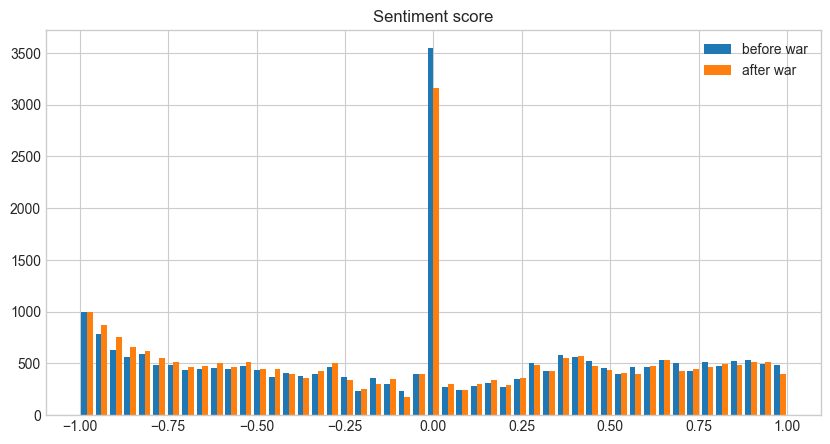

In [27]:
# sentiment score
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10,5))

x = df_before_war['sentiment_score']
y = df_after_war['sentiment_score']
bins = np.linspace(-1, 1)

plt.title('Sentiment score')
plt.hist([x, y], bins, label=['before war', 'after war'])
plt.legend(loc='upper right')

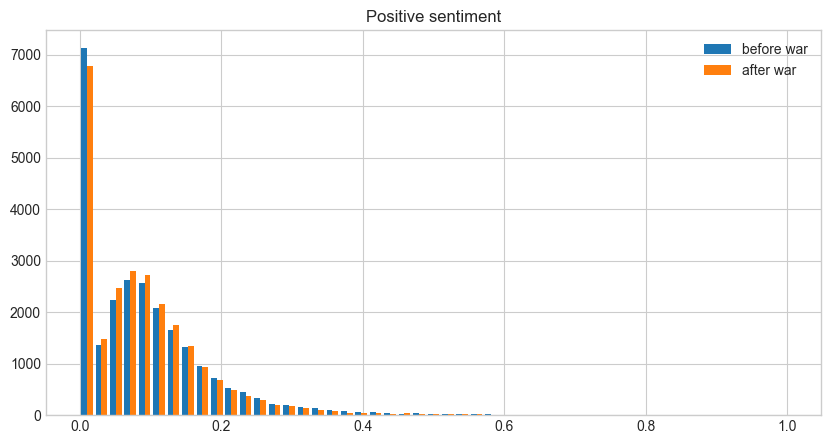

In [28]:
# positive sentiment
plt.figure(figsize=(10,5))

x = df_before_war['sentiment_pos']
y = df_after_war['sentiment_pos']
bins = np.linspace(0, 1)

plt.title('Positive sentiment')
plt.hist([x, y], bins, label=['before war', 'after war'])
plt.legend(loc='upper right')

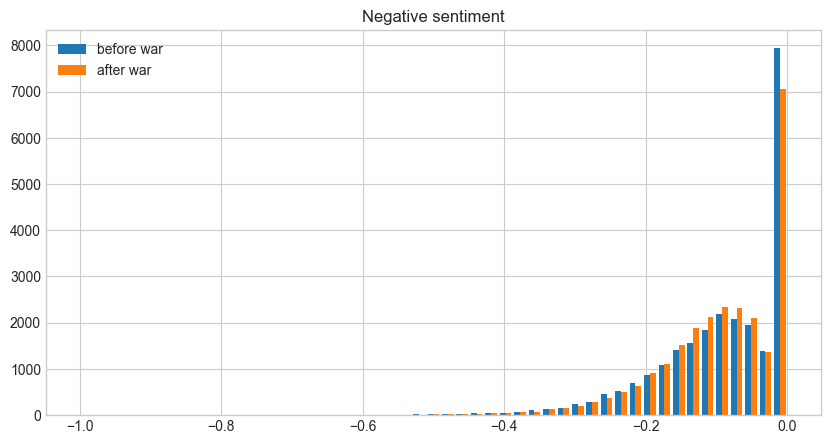

In [29]:
# negative sentiment
plt.figure(figsize=(10,5))

x = df_before_war['sentiment_neg']*(-1)
y = df_after_war['sentiment_neg']*(-1)
bins = np.linspace(-1, 0)

plt.title('Negative sentiment')
plt.hist([x, y], bins, label=['before war', 'after war'])
plt.legend(loc='upper left')